In [1]:
from acoular import *
from os import path
from acoular import __file__ as bpath
import matplotlib.pyplot as plt

In [2]:
micgeofile = path.join(path.split(bpath)[0], 'xml', 'array_64.xml')

In [3]:
SFREQ = 51200
TIME = 1
NUM_SAMPLES = TIME * SFREQ
BLOCK_SIZE = 1024
MICGEOM = MicGeom(from_file=micgeofile) 

In [4]:
#
h5savefile = 'Test_dat.h5'
n = WNoiseGenerator(sample_freq=SFREQ, numsamples=NUM_SAMPLES, seed=0)
p = PointSource(signal=n, mics=MICGEOM, loc=(0.5,0.0,0.75))
wh5 = WriteH5(source=p, name=h5savefile)
wh5.save()

In [5]:
#define boundry for positional and source strenght variation
GRID_BOUNDS = [(-1, 1), (-1, 1), (0.75, 0.75), (0, 1)]
PG = create_rand_pgrid(GRID_BOUNDS, 1) 
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)

In [9]:
ts = TimeSamples(name='Test_dat.h5')
ps = PowerSpectra(time_data=ts, block_size=BLOCK_SIZE, window='Hanning')
bea = BeamformerEA(freq_data=ps, grid=PG, mpos=MICGEOM)

/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:3: Warning: Deprecated use of 'grid' trait. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:3: Warning: Deprecated use of 'mpos' trait. 
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
res_BEA = bea.calculate(GRID_BOUNDS, 800)

/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/acoular/fbeamform.py:2311: Warning: Deprecated use of 'grid' trait. 
  mpos=self.mpos, env=self.env)
/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/acoular/fbeamform.py:2311: Warning: Deprecated use of 'mpos' trait. 
  mpos=self.mpos, env=self.env)
/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/acoular/fbeamform.py:2311: Warning: Deprecated use of 'env' trait. 
  mpos=self.mpos, env=self.env)


[('Test_dat_cache.h5', 1)]


/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


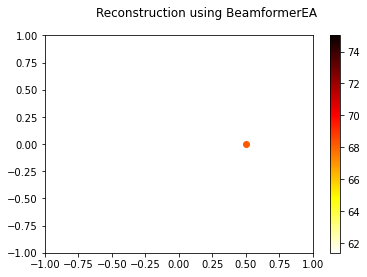

In [38]:
plt.figure()
plt.scatter(res_BEA.x[0],res_BEA.x[1],c=L_p(res_BEA.x[3]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerEA")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

In [39]:
L_p(res_BEA.x[3])

68.19856249975533

In [12]:
beb = BeamformerBase(freq_data=ps,grid=GR, mpos=MICGEOM)
res_BEB = beb.synthetic(800,0)

[('Test_dat_cache.h5', 2)]


/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:1: Warning: Deprecated use of 'grid' trait. 
  """Entry point for launching an IPython kernel.
/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:1: Warning: Deprecated use of 'mpos' trait. 
  """Entry point for launching an IPython kernel.


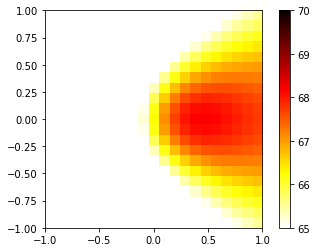

In [41]:
im = plt.imshow(L_p(res_BEB.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerBase")
plt.colorbar()

In [21]:
becmf = BeamformerCMF(freq_data=ps,grid=GR, mpos=MICGEOM)
res_CMF = becmf.synthetic(800,0)

[('Test_dat_cache.h5', 7)]


/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:1: Warning: Deprecated use of 'grid' trait. 
  """Entry point for launching an IPython kernel.
/home/mikolaj/anaconda3/envs/acoular/lib/python3.6/site-packages/ipykernel_launcher.py:1: Warning: Deprecated use of 'mpos' trait. 
  """Entry point for launching an IPython kernel.


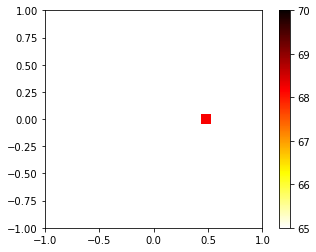

In [40]:
im = plt.imshow(L_p(res_CMF.T),vmax=70,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerBase")

plt.colorbar()